In [35]:
import pandas as pd
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
comments_df = pd.read_csv('../data/YTcomments.csv')
comments_df.head()

,Comment
0,Copy nothing? More like understand nothing.
1,De macho Alfa lomo plateado pelo en pecho a co...
2,Où sont les voitures ? Cest quoi cest guignols...
3,This thing is just a waste of time where is th...
4,WTF did I just watch?


Let the cleaning begin!!
1) get rid of all non-english comments 
2) ill come up with more stuff 

In [5]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

In [9]:
# Function to detect if a comment is in English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # Handle cases where detection fails (e.g., empty strings)

# Ensure all entries in "Comment" are strings
comments_df['Comment'] = comments_df['Comment'].astype(str)

# Filter rows where "Comment" is detected as English
en_comments = comments_df[comments_df['Comment'].apply(is_english)]


The dataframe is composed of only english comments, now time to perform the sentiment analysis

Need a model familiar with sarcasm, and one pretrained on social media language: enter BERTweet

In [14]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment", num_labels=3)  # Adjust for 3 classes if needed

# Tokenize the comments
def preprocess_comments(comments):
    return tokenizer(comments, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Apply to the 'Comment' column
inputs = preprocess_comments(en_comments['Comment'].tolist())


In [15]:
# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Extract predictions
predictions = torch.argmax(outputs.logits, dim=1).numpy()


In [17]:
# Map numeric labels to sentiment
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}  # Adjust based on model training
en_comments['Sentiment'] = [label_map[pred] for pred in predictions]

# Save the results
en_comments.to_csv('sentiment_results.csv', index=False)
print("Sentiment analysis completed. Results saved to 'sentiment_results.csv'")


Sentiment analysis completed. Results saved to 'sentiment_results.csv'


/var/folders/tj/107lbdtn5tg9w338mn510w480000gn/T/ipykernel_2021/1616205542.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_comments['Sentiment'] = [label_map[pred] for pred in predictions]


In [27]:
sentiment_df = pd.read_csv('../data/sentiment_results.csv')

Sentiment
Negative    36
Neutral     28
Positive     3
Name: count, dtype: int64


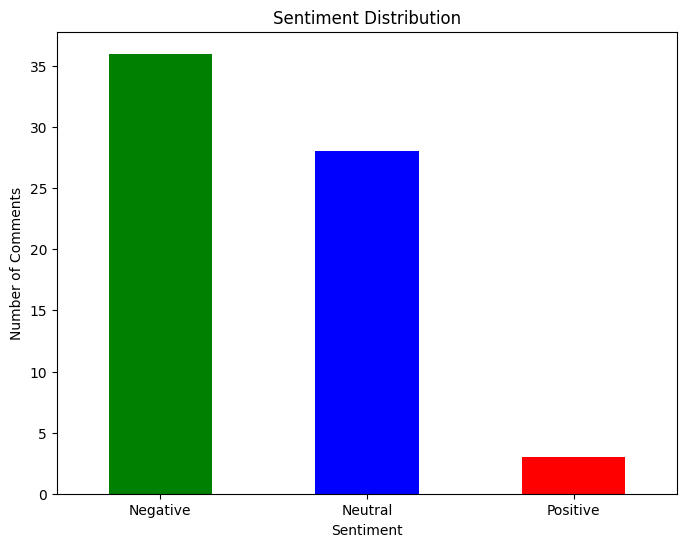

In [34]:
# Plot a bar chart
sentiment_counts = sentiment_df['Sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.show()


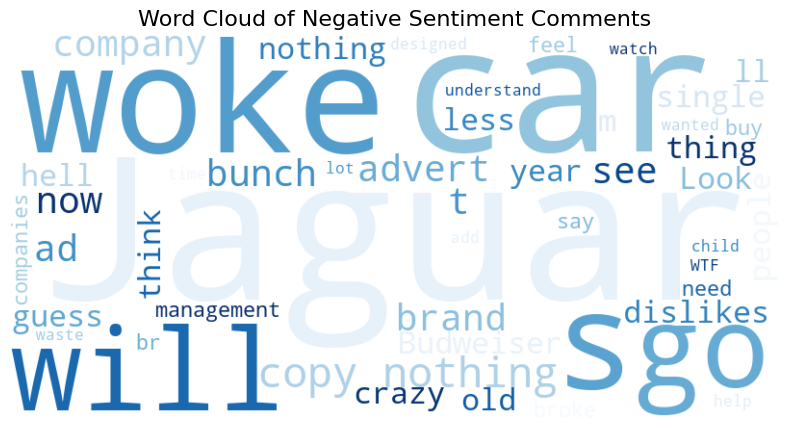

In [47]:
# Load the dataset
df = pd.read_csv('../data/sentiment_results.csv')

# Filter comments with negative sentiment
negative_comments = df[df['Sentiment'] == 'Negative']['Comment']

# Combine all negative comments into a single string
text = " ".join(negative_comments)

# Generate a word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Blues',  # Color scheme for negative sentiment
    max_words=50,
    stopwords=None  # Add custom stopwords if needed
).generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Negative Sentiment Comments', fontsize=16)
plt.show()

[nltk_data] Downloading package stopwords to /Users/tejus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tejus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/tejus/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


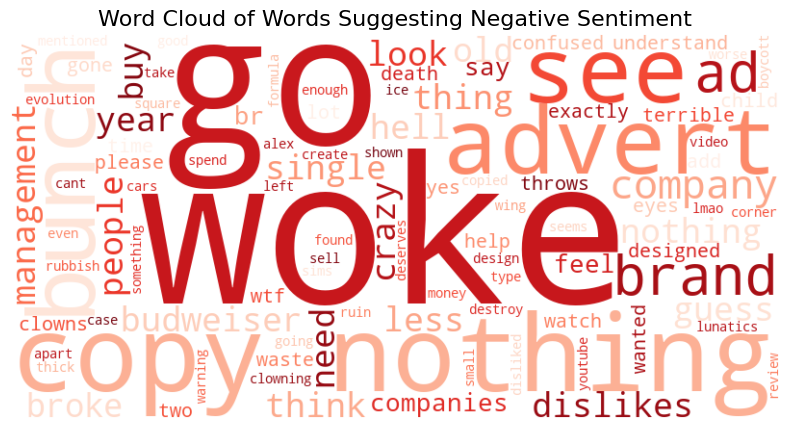

In [54]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Ensure necessary NLTK data is downloaded
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt_tab')

# Load the dataset
df = pd.read_csv('../data/sentiment_results.csv')

# Filter negative sentiment comments
negative_comments = df[df['Sentiment'] == 'Negative']['Comment']

# Combine all negative comments into a single string
text = " ".join(negative_comments)

# Tokenize and clean the text
tokens = word_tokenize(text.lower())
stop_words = set(stopwords.words('english'))  # NLTK stopwords
custom_stopwords = set(['jaguar', 'car', '!', '.', ',', '?', '...', '“', '”', '-', "'s", "'"])  # Include "Jaguar" and "Car"
filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words and word not in custom_stopwords]
# Combine the cleaned words into a single string
cleaned_text = " ".join(filtered_words)

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    max_words=100
).generate(cleaned_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.title('Word Cloud of Words Suggesting Negative Sentiment', fontsize=16)
plt.show()
